In [3]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score

import shap

In [4]:
batch_size = 128
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the dataset
dataset = torchvision.datasets.STL10(
    root='./data',
    split='train',  # Use the labeled training split
    download=True,
    transform=transform
)

# Get indices for splitting
total_indices = list(range(len(dataset)))  # Indices for the full dataset
np.random.shuffle(total_indices)  # Shuffle indices for randomness

# Split into two halves
mid_point = len(total_indices) // 2
target_indices = total_indices[:mid_point]  # First half for the target model
shadow_indices = total_indices[mid_point:]  # Second half for the shadow model

# Split each half into 80-20 train-test
def split_indices(indices, train_ratio=0.8):
    split_point = int(len(indices) * train_ratio)
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]
    return train_indices, test_indices

target_train_indices, target_test_indices = split_indices(target_indices)
shadow_train_indices, shadow_test_indices = split_indices(shadow_indices)

# Create subsets for DataLoader
target_train_dataset = Subset(dataset, target_train_indices)
target_test_dataset = Subset(dataset, target_test_indices)
shadow_train_dataset = Subset(dataset, shadow_train_indices)
shadow_test_dataset = Subset(dataset, shadow_test_indices)

# Create DataLoaders
target_train_loader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
target_test_loader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
shadow_train_loader = DataLoader(shadow_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
shadow_test_loader = DataLoader(shadow_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Target Train Size: {len(target_train_indices)}, Target Test Size: {len(target_test_indices)}")
print(f"Shadow Train Size: {len(shadow_train_indices)}, Shadow Test Size: {len(shadow_test_indices)}")

Files already downloaded and verified
Target Train Size: 2000, Target Test Size: 500
Shadow Train Size: 2000, Shadow Test Size: 500


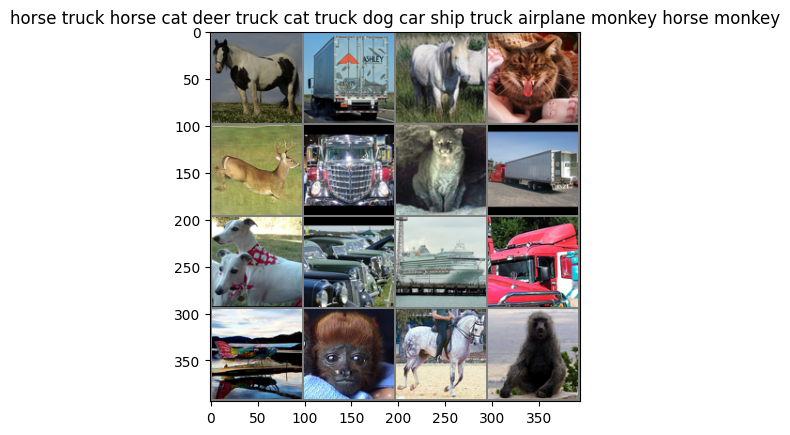

In [10]:
# Access the original dataset's classes
classes = dataset.classes

# Example of displaying a batch of images with class names
data_iter = iter(shadow_train_loader)
images, labels = next(data_iter)

# Function to display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Display a batch of images with class names
import matplotlib.pyplot as plt

imshow(torchvision.utils.make_grid(images[:16], nrow=4),  # Show first 16 images in a grid
       title=' '.join(classes[labels[j]] for j in range(16)))


In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # out += identity
        out = out + identity
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, grayscale=False):
        super(ResNet18, self).__init__()
        in_channels = 1 if grayscale else 3  # Adjust input channels for grayscale
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [12]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



In [13]:
# Target Model Training
target_model = ResNet18(num_classes=10).to(device)
optimizer = optim.Adam(target_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
train_model(target_model, target_train_loader, criterion, optimizer, num_epochs, device)

Epoch [1/100], Loss: 1.9570
Epoch [2/100], Loss: 1.0711
Epoch [3/100], Loss: 0.3338
Epoch [4/100], Loss: 0.0501
Epoch [5/100], Loss: 0.0138
Epoch [6/100], Loss: 0.0065
Epoch [7/100], Loss: 0.0044
Epoch [8/100], Loss: 0.0034
Epoch [9/100], Loss: 0.0032
Epoch [10/100], Loss: 0.0027
Epoch [11/100], Loss: 0.0024
Epoch [12/100], Loss: 0.0021
Epoch [13/100], Loss: 0.0019
Epoch [14/100], Loss: 0.0018
Epoch [15/100], Loss: 0.0017
Epoch [16/100], Loss: 0.0014
Epoch [17/100], Loss: 0.0015
Epoch [18/100], Loss: 0.0013
Epoch [19/100], Loss: 0.0012
Epoch [20/100], Loss: 0.0011
Epoch [21/100], Loss: 0.0011
Epoch [22/100], Loss: 0.0010
Epoch [23/100], Loss: 0.0011
Epoch [24/100], Loss: 0.0010
Epoch [25/100], Loss: 0.0009
Epoch [26/100], Loss: 0.0009
Epoch [27/100], Loss: 0.0008
Epoch [28/100], Loss: 0.0007
Epoch [29/100], Loss: 0.0008
Epoch [30/100], Loss: 0.0007
Epoch [31/100], Loss: 0.0008
Epoch [32/100], Loss: 0.0007
Epoch [33/100], Loss: 0.0006
Epoch [34/100], Loss: 0.0006
Epoch [35/100], Loss: 0

In [15]:
torch.save(target_model.state_dict(), "resnet18_stl10_black_box_model_target.pth")


In [16]:
# Shadow Model Training
shadow_model = ResNet18(num_classes=10).to(device)
optimizer_shadow = optim.Adam(shadow_model.parameters(), lr=1e-4)
train_model(shadow_model, shadow_train_loader, criterion, optimizer_shadow, num_epochs, device)

Epoch [1/100], Loss: 1.9324
Epoch [2/100], Loss: 1.0724
Epoch [3/100], Loss: 0.3294
Epoch [4/100], Loss: 0.0522
Epoch [5/100], Loss: 0.0139
Epoch [6/100], Loss: 0.0072
Epoch [7/100], Loss: 0.0046
Epoch [8/100], Loss: 0.0036
Epoch [9/100], Loss: 0.0031
Epoch [10/100], Loss: 0.0026
Epoch [11/100], Loss: 0.0024
Epoch [12/100], Loss: 0.0021
Epoch [13/100], Loss: 0.0021
Epoch [14/100], Loss: 0.0019
Epoch [15/100], Loss: 0.0017
Epoch [16/100], Loss: 0.0016
Epoch [17/100], Loss: 0.0014
Epoch [18/100], Loss: 0.0015
Epoch [19/100], Loss: 0.0013
Epoch [20/100], Loss: 0.0012
Epoch [21/100], Loss: 0.0012
Epoch [22/100], Loss: 0.0011
Epoch [23/100], Loss: 0.0010
Epoch [24/100], Loss: 0.0009
Epoch [25/100], Loss: 0.0010
Epoch [26/100], Loss: 0.0010
Epoch [27/100], Loss: 0.0008
Epoch [28/100], Loss: 0.0008
Epoch [29/100], Loss: 0.0008
Epoch [30/100], Loss: 0.0007
Epoch [31/100], Loss: 0.0007
Epoch [32/100], Loss: 0.0007
Epoch [33/100], Loss: 0.0007
Epoch [34/100], Loss: 0.0007
Epoch [35/100], Loss: 0

In [17]:
torch.save(shadow_model.state_dict(), "resnet18_stl10_black_box_model_shadow.pth")


In [18]:
# Function to extract features and create attack dataset (with label as a feature)
def create_attack_dataset_with_labels(model, data_loader, device, label):
    features, labels = [], []
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Model outputs
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_label = torch.argmax(probabilities, dim=1)
            loss = F.cross_entropy(outputs, targets, reduction='none').cpu()

            # Combine features (posteriors, loss, true label as one-hot encoding)
            true_label_one_hot = F.one_hot(targets, num_classes=probabilities.size(1)).float()
            attack_features = torch.cat(
                (probabilities.cpu(), loss.unsqueeze(1), true_label_one_hot.cpu()),
                dim=1
            )
            features.append(attack_features)
            labels.extend([label] * len(targets))
    
    return torch.cat(features, dim=0), torch.tensor(labels)


#shadow train data

In [42]:
# Shadow model features with label as a feature
shadow_member_features, shadow_member_labels = create_attack_dataset_with_labels(shadow_model, shadow_train_loader, device, 1)
shadow_non_member_features, shadow_non_member_labels = create_attack_dataset_with_labels(shadow_model, shadow_test_loader, device, 0)

# Combine to create the full attack dataset
attack_features = torch.cat((shadow_member_features, shadow_non_member_features), dim=0)
attack_labels = torch.cat((shadow_member_labels, shadow_non_member_labels), dim=0)

# Prepare DataLoader for attack training
attack_dataset = TensorDataset(attack_features, attack_labels)
attack_loader = DataLoader(attack_dataset, batch_size=batch_size, shuffle=True)


In [23]:
shadow_member_features[0]

tensor([9.0668e-06, 3.0307e-06, 1.3716e-05, 7.7084e-06, 4.9849e-06, 1.6866e-05,
        1.2074e-05, 5.0437e-06, 3.8266e-06, 9.9992e-01, 7.6172e-05, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00])

In [24]:
class AttackModel(nn.Module):
    def __init__(self, input_dim):
        super(AttackModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Train the attack model


In [25]:
attack_model = AttackModel(input_dim=attack_features.shape[1]).to(device)
optimizer_attack = optim.Adam(attack_model.parameters(), lr=1e-4)
criterion_attack = nn.BCELoss()

In [28]:
num_epochs = 100
attack_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for features, labels in attack_loader:
        features, labels = features.to(device), labels.to(device).float()
        optimizer_attack.zero_grad()
        outputs = attack_model(features).squeeze()
        loss = criterion_attack(outputs, labels)
        loss.backward()
        optimizer_attack.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Attack Loss: {running_loss/len(attack_loader):.4f}")

Epoch [1/100], Attack Loss: 0.1019
Epoch [2/100], Attack Loss: 0.1010
Epoch [3/100], Attack Loss: 0.0997
Epoch [4/100], Attack Loss: 0.1026
Epoch [5/100], Attack Loss: 0.0976
Epoch [6/100], Attack Loss: 0.0992
Epoch [7/100], Attack Loss: 0.0973
Epoch [8/100], Attack Loss: 0.0982
Epoch [9/100], Attack Loss: 0.1019
Epoch [10/100], Attack Loss: 0.1019
Epoch [11/100], Attack Loss: 0.1012
Epoch [12/100], Attack Loss: 0.0964
Epoch [13/100], Attack Loss: 0.0985
Epoch [14/100], Attack Loss: 0.0995
Epoch [15/100], Attack Loss: 0.1035
Epoch [16/100], Attack Loss: 0.0995
Epoch [17/100], Attack Loss: 0.1007
Epoch [18/100], Attack Loss: 0.0987
Epoch [19/100], Attack Loss: 0.1027
Epoch [20/100], Attack Loss: 0.1035
Epoch [21/100], Attack Loss: 0.0975
Epoch [22/100], Attack Loss: 0.1001
Epoch [23/100], Attack Loss: 0.0966
Epoch [24/100], Attack Loss: 0.0940
Epoch [25/100], Attack Loss: 0.1010
Epoch [26/100], Attack Loss: 0.0920
Epoch [27/100], Attack Loss: 0.0949
Epoch [28/100], Attack Loss: 0.0952
E

In [29]:
torch.save(attack_model.state_dict(), "black_box_attack_model.pth")


#shadow test data

In [40]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_attack_model(model, data_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).long().squeeze()  # Convert logits to binary predictions
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy and F1-score
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return acc, f1

In [46]:
# Extract features for attack testing (shadow test data)
shadow_test_member_features, shadow_test_member_labels = create_attack_dataset_with_labels(shadow_model, shadow_test_loader, device, 1)
shadow_test_non_member_features, shadow_test_non_member_labels = create_attack_dataset_with_labels(shadow_model, shadow_test_loader, device, 0)

# Combine to create the full attack test dataset
test_features = torch.cat((shadow_test_member_features, shadow_test_non_member_features), dim=0)
test_labels = torch.cat((shadow_test_member_labels, shadow_test_non_member_labels), dim=0)

# Prepare DataLoader for attack testing
attack_test_dataset = TensorDataset(test_features, test_labels)
attack_test_loader = DataLoader(attack_test_dataset, batch_size=batch_size, shuffle=False)


In [47]:
attack_accuracy, attack_f1 = evaluate_attack_model(attack_model, attack_test_loader, device)
print(f"Attack Model Accuracy: {attack_accuracy:.4f}")
print(f"Attack Model F1-Score: {attack_f1:.4f}")


Attack Model Accuracy: 0.5000
Attack Model F1-Score: 0.2013


In [48]:
#target model train data

In [53]:
target_test_member_features, target_test_member_labels = create_attack_dataset_with_labels(target_model, target_train_loader, device, 1)
target_test_non_member_features, target_test_non_member_labels = create_attack_dataset_with_labels(target_model, target_test_loader, device, 0)

# Combine to create the full attack test dataset
test_features = torch.cat((target_test_member_features, target_test_non_member_features), dim=0)
test_labels = torch.cat((target_test_member_labels, shadow_test_non_member_labels), dim=0)

# Prepare DataLoader for attack testing
attack_test_dataset = TensorDataset(test_features, test_labels)
attack_test_loader = DataLoader(attack_test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
attack_accuracy, attack_f1 = evaluate_attack_model(attack_model, attack_test_loader, device)
print(f"Attack Model Accuracy: {attack_accuracy:.4f}")
print(f"Attack Model F1-Score: {attack_f1:.4f}")


Attack Model Accuracy: 0.9740
Attack Model F1-Score: 0.9840


In [73]:
# class CombinedModel(nn.Module):
#     def __init__(self, shadow_model, attack_model):

#         super(CombinedModel, self).__init__()
#         self.shadow_model = shadow_model
#         self.attack_model = attack_model
    
#     def forward(self, x):

#         with torch.no_grad():  # Freeze shadow model parameters
#             features = self.shadow_model(x)
#         output = self.attack_model(features)
#         return output

class CombinedModel(nn.Module):
    def __init__(self, shadow_model, attack_model):
        super(CombinedModel, self).__init__()
        self.shadow_model = shadow_model
        self.attack_model = attack_model

    def forward(self, x, targets=None):
        with torch.no_grad():  # Freeze shadow model parameters
            # Shadow model outputs logits (shape: [batch_size, 10])
            logits = self.shadow_model(x)
            probabilities = torch.softmax(logits, dim=1)  # Probabilities (shape: [batch_size, 10])

            if targets is not None:
                # Compute cross-entropy loss for each sample
                loss = F.cross_entropy(logits, targets, reduction='none').unsqueeze(1)  # Shape: [batch_size, 1]

                # Convert targets to one-hot encoding
                true_label_one_hot = F.one_hot(targets, num_classes=logits.size(1)).float()  # Shape: [batch_size, 10]

                # Combine features (probabilities, loss, true labels)
                attack_features = torch.cat((probabilities, loss, true_label_one_hot), dim=1)  # Shape: [batch_size, 21]
            else:
                # If targets are not provided (e.g., during inference), exclude loss and labels
                attack_features = probabilities  # Shape: [batch_size, 10]
        
        # Pass combined features to the attack model
        output = self.attack_model(attack_features)
        return output


In [74]:
shadow_model.eval()  # Ensure the shadow model is in evaluation mode
attack_model.eval()  # Ensure the attack model is in evaluation mode

# Create the combined model
combined_model = CombinedModel(shadow_model, attack_model).to(device)

In [75]:
data_iter_test = iter(target_test_loader)
X_test, y_test = next(data_iter_test)

In [76]:
X_test_numpy = X_test.permute(0, 2, 3, 1).numpy()  # [B, C, H, W] -> [B, H, W, C]

# Ensure the data type is uint8 and values are scaled to [0, 255]
X_test_numpy = (X_test_numpy * 255).astype(np.uint8)

# Define the masker with the corrected shape
masker = shap.maskers.Image("inpaint_telea", X_test_numpy[0].shape)

# Define the model function for SHAP
def f(x):
    # Convert from [B, H, W, C] to [B, C, H, W] for PyTorch
    x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    with torch.no_grad():
        return combined_model(x_tensor).cpu().numpy()

# Initialize SHAP explainer
explainer = shap.Explainer(f, masker)

# Explain two images using SHAP
shap_values = explainer(X_test_numpy[50:82], max_evals=100, batch_size=1)

# Plot the SHAP values
shap.image_plot(shap_values, X_test_numpy[50:51])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 21x128)